# MMAE 450 In-Class Demo: Finite Volume Method for 1D Advection–Diffusion (Dirichlet BCs)

**Goal:** Implement the 1D finite volume method (FVM) for advection–diffusion with constant velocity and Dirichlet boundary conditions at both ends.

By the end of this demo you should be able to:
- Write the conservative flux form of the PDE
- Discretize in space with finite volumes (fluxes at faces)
- Handle Dirichlet boundary conditions using boundary face fluxes (pure FVM)
- Visualize how advection and diffusion shape the solution

## 1. Problem Statement (PDE + BC/IC)

We solve:
\begin{equation}
\frac{\partial T}{\partial t} + v \frac{\partial T}{\partial x}
= \alpha \frac{\partial^2 T}{\partial x^2}, \quad 0<x<L
\end{equation}

Dirichlet boundary conditions:
\begin{equation}
T(0,t)=T_L,\qquad T(L,t)=T_R
\end{equation}

Initial condition:
\begin{equation}
T(x,0)=0
\end{equation}

Interpretation: a “temperature / concentration” field convected right by constant velocity while diffusing.

## 2. Conservative (Flux) Form

Write the PDE as:
\begin{equation}
\frac{\partial T}{\partial t} + \frac{\partial F}{\partial x} = 0,
\qquad
F = vT - \alpha \frac{\partial T}{\partial x}.
\end{equation}

Finite volume update for cell \(i\):
\begin{equation}
\Delta x \frac{dT_i}{dt} = F_{i-\frac12} - F_{i+\frac12}.
\end{equation}

## 3. Face Flux Approximations (Central)

Interior faces:
\begin{equation}
T_{i+\frac12} \approx \frac{T_i + T_{i+1}}{2},
\qquad
\left.\frac{\partial T}{\partial x}\right|_{i+\frac12}
\approx \frac{T_{i+1}-T_i}{\Delta x}.
\end{equation}

So:
\begin{equation}
F_{i+\frac12}= v\frac{T_i+T_{i+1}}{2} - \alpha \frac{T_{i+1}-T_i}{\Delta x}.
\end{equation}

## 4. Dirichlet Boundary Conditions in Pure FVM Form

Boundaries are faces (not cell centers).

Left boundary face at $x=\frac12\Delta x$ relative to first cell:
- Dirichlet gives $T_{-\frac12}=T_L$
- Use one-sided gradient over $\Delta x/2$:
\begin{equation}
\left.\frac{\partial T}{\partial x}\right|_{-\frac12}
\approx \frac{T_0 - T_L}{\Delta x/2}.
\end{equation}
So:
\begin{equation}
F_{-\frac12} = vT_L - \alpha \frac{T_0 - T_L}{\Delta x/2}.
\end{equation}

Similarly at the right boundary:
\begin{equation}
F_{N-\frac12} = vT_R - \alpha \frac{T_R - T_{N-1}}{\Delta x/2}.
\end{equation}

In [132]:
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt

In [133]:
import numpy as np

def adv_flux_central(TL, TR, v):
    """Central (2nd-order) advective flux at a face."""
    return 0.5 * v * (TL + TR)

def adv_flux_upwind(TL, TR, v):
    """Upwind (1st-order) advective flux at a face."""
    return v * (TL if v >= 0.0 else TR)

def diff_flux_central(TL, TR, alpha, dx_face):
    """Central diffusive flux at a face: -alpha dT/dx."""
    return -alpha * (TR - TL) / dx_face

In [134]:
# Define user input
L = 1000.0
N = 200
dx = L / N
dt = 0.1
alpha = 0.5
v = 2.0  # (m/s)

T_L = 0.0
T_R = 0.0

x = np.linspace(dx/2, L - dx/2, N)

# Set up Temperature array (time x cells)
nsteps = 2000
T = np.zeros((nsteps+1, N))

# Top-hat pulse between x1 and x2
x1, x2 = 0.4*L, 0.6*L
A = 1.0

T[0, :] = T_L
T[0, (x >= x1) & (x <= x2)] = T_L + A

T[0, 0]  = T_L
T[0, -1] = T_R

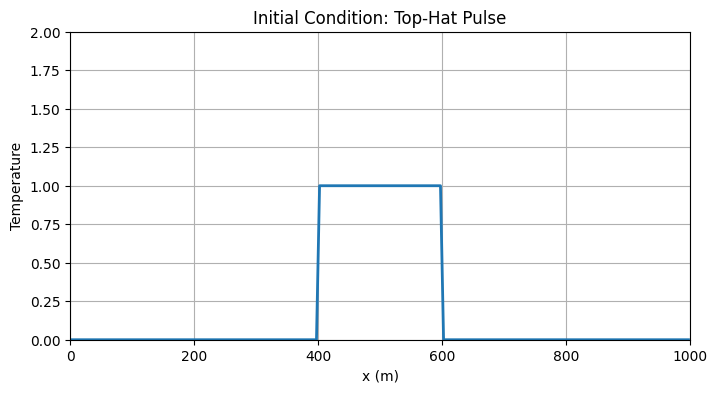

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(x, T[0, :], linewidth=2)
plt.xlabel("x (m)")
plt.ylabel("Temperature")
plt.title("Initial Condition: Top-Hat Pulse")
plt.grid(True)
plt.xlim(0, L)
plt.ylim(0, 2)
plt.show()

In [136]:
# Choose advection scheme here:
adv_flux = adv_flux_upwind      # <-- switch to adv_flux_central if desired

for n in range(nsteps):

    # ---------- Left boundary cell i=0 ----------
    # Face at x=0 (boundary-to-cell distance = dx/2)
    F_left  = adv_flux(T_L, T[n, 0], v) + diff_flux_central(T_L, T[n, 0], alpha, dx/2)

    # Face at i+1/2 between cells 0 and 1 (distance = dx)
    F_right = adv_flux(T[n, 0], T[n, 1], v) + diff_flux_central(T[n, 0], T[n, 1], alpha, dx)

    T[n+1, 0] = T[n, 0] - (dt/dx) * (F_right - F_left)


    # ---------- Right boundary cell i=N-1 (outflow + insulated) ----------
    # Right boundary face at x=L:
    F_right = v * T[n, N-1]   # advection outflow uses interior value
    # diffusion part = 0 because dT/dx(L,t) = 0
    F_left  = adv_flux(T[n, N-2], T[n, N-1], v) + diff_flux_central(T[n, N-2], T[n, N-1], alpha, dx)

    T[n+1, N-1] = T[n, N-1] - (dt/dx) * (F_right - F_left)

    # ---------- Right boundary cell i=N-1 ----------
    # Face at x=L (cell-to-boundary distance = dx/2)
    #F_right = adv_flux(T[n, N-1], T_R, v) + diff_flux_central(T[n, N-1], T_R, alpha, dx/2)

    # Face at i-1/2 between cells N-2 and N-1
    #F_left  = adv_flux(T[n, N-2], T[n, N-1], v) + diff_flux_central(T[n, N-2], T[n, N-1], alpha, dx)

    #T[n+1, N-1] = T[n, N-1] - (dt/dx) * (F_right - F_left)

    # ---------- Interior cells i=1..N-2 ----------
    for i in range(1, N-1):
        F_right = adv_flux(T[n, i],   T[n, i+1], v) + diff_flux_central(T[n, i],   T[n, i+1], alpha, dx)
        F_left  = adv_flux(T[n, i-1], T[n, i],   v) + diff_flux_central(T[n, i-1], T[n, i],   alpha, dx)

        T[n+1, i] = T[n, i] - (dt/dx) * (F_right - F_left)

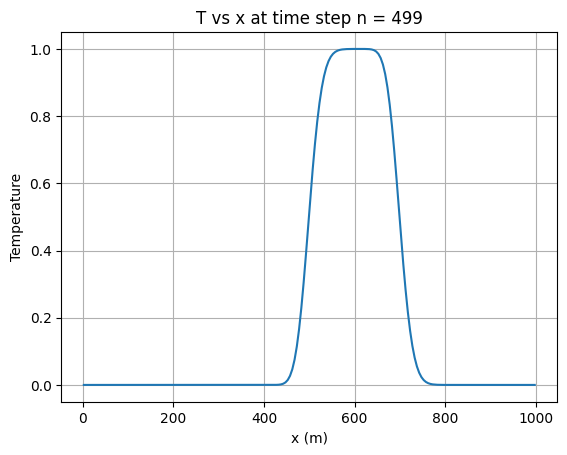

In [137]:
n_plot = 499   # choose time step

plt.figure()
plt.plot(x, T[n_plot, :])
plt.xlabel("x (m)")
plt.ylabel("Temperature")
plt.title(f"T vs x at time step n = {n_plot}")
plt.grid(True)
plt.show()

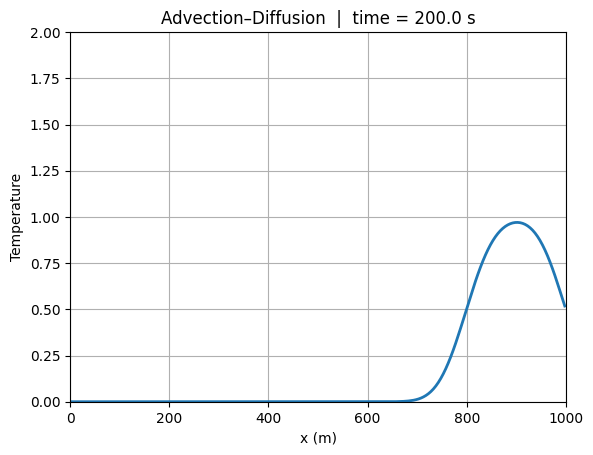

In [140]:
from IPython.display import clear_output

plt.figure(figsize=(8,4))

for n in range(0, nsteps+1, 200):
    clear_output(wait=True)
    
    plt.clf()
    plt.plot(x, T[n, :], linewidth=2)
    plt.xlabel("x (m)")
    plt.ylabel("Temperature")
    plt.title(f"Advection–Diffusion  |  time = {n*dt:.1f} s")
    plt.xlim(0, L)
    plt.ylim(0, 2)
    plt.grid(True)
    
    plt.pause(0.05)

plt.show()